<a href="https://colab.research.google.com/github/munishkap/retailrag/blob/main/retail_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%pip install openai --quiet
%pip install tenacity --quiet
%pip install tqdm --quiet
%pip install numpy --quiet
%pip install typing --quiet
%pip install tiktoken --quiet


In [15]:
import getpass
import os
import pandas as pd
import numpy as np
import json
import ast
import tiktoken
import concurrent.futures
from openai import OpenAI
from tqdm import tqdm
from tenacity import retry, wait_random_exponential, stop_after_attempt
from IPython.display import Image, display, HTML
from typing import List


key = getpass.getpass('Enter the OpenAI key')
os.environ['OPENAI_API_KEY'] = key


client = OpenAI()


GPT_MODEL = "gpt-4o-mini"
EMBEDDING_MODEL = "text-embedding-3-large"
EMBEDDING_COST_PER_1K_TOKENS = 0.00013

Enter the OpenAI key··········


In [16]:
styles_filepath = "/content/sample_styles.csv"
styles_df = pd.read_csv(styles_filepath, on_bad_lines='skip')
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt  
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts  
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt  
3  2012.0  Ethnic                  Fabindia Men Blue Kurta  
4  2012.0  Ethnic        Shree Women Multi Colored Patiala  
Opened dataset successfully. Dataset has 1000 items of clothing.


In [17]:
## Batch Embedding Logic

# Simple function to take in a list of text objects and return them as a list of embeddings
@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(10))
def get_embeddings(input: List):
    response = client.embeddings.create(
        input=input,
        model=EMBEDDING_MODEL
    ).data
    return [data.embedding for data in response]


# Splits an iterable into batches of size n.
def batchify(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx : min(ndx + n, l)]


# Function for batching and parallel processing the embeddings
def embed_corpus(
    corpus: List[str],
    batch_size=64,
    num_workers=8,
    max_context_len=8191,
):
    # Encode the corpus, truncating to max_context_len
    encoding = tiktoken.get_encoding("cl100k_base")
    encoded_corpus = [
        encoded_article[:max_context_len] for encoded_article in encoding.encode_batch(corpus)
    ]

    # Calculate corpus statistics: the number of inputs, the total number of tokens, and the estimated cost to embed
    num_tokens = sum(len(article) for article in encoded_corpus)
    cost_to_embed_tokens = num_tokens / 1000 * EMBEDDING_COST_PER_1K_TOKENS
    print(
        f"num_articles={len(encoded_corpus)}, num_tokens={num_tokens}, est_embedding_cost={cost_to_embed_tokens:.2f} USD"
    )

    # Embed the corpus
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:

        futures = [
            executor.submit(get_embeddings, text_batch)
            for text_batch in batchify(encoded_corpus, batch_size)
        ]

        with tqdm(total=len(encoded_corpus)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(batch_size)

        embeddings = []
        for future in futures:
            data = future.result()
            embeddings.extend(data)

        return embeddings


# Function to generate embeddings for a given column in a DataFrame
def generate_embeddings(df, column_name):
    # Initialize an empty list to store embeddings
    descriptions = df[column_name].astype(str).tolist()
    embeddings = embed_corpus(descriptions)

    # Add the embeddings as a new column to the DataFrame
    df['embeddings'] = embeddings
    print("Embeddings created successfully.")

In [18]:
generate_embeddings(styles_df, 'productDisplayName')
print("Writing embeddings to file ...")
styles_df.to_csv('/content/sample_styles_with_embeddings.csv', index=False)
print("Embeddings successfully stored in sample_styles_with_embeddings.csv")

num_articles=1000, num_tokens=8280, est_embedding_cost=0.00 USD


1024it [00:02, 456.62it/s]                         


Embeddings created successfully.
Writing embeddings to file ...
Embeddings successfully stored in sample_styles_with_embeddings.csv


In [19]:
# styles_df = pd.read_csv('data/sample_clothes/sample_styles_with_embeddings.csv', on_bad_lines='skip')

# # Convert the 'embeddings' column from string representations of lists to actual lists of floats
# styles_df['embeddings'] = styles_df['embeddings'].apply(lambda x: ast.literal_eval(x))

print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing along with their embeddings.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  \
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt   
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts   
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt   
3  2012.0  Ethnic                  Fabindia Men Blue Kurta   
4  2012.0  Ethnic        Shree Women Multi Colored Patiala   

                                          embeddings  
0  [0.006910496857017279, 0.0002929018228314817, ...  
1  [-0.0437035895884037, -0.008875241503119469, -...  

In [20]:
def cosine_similarity_manual(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    vec1 = np.array(vec1, dtype=float)
    vec2 = np.array(vec2, dtype=float)


    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)


def find_similar_items(input_embedding, embeddings, threshold=0.5, top_k=2):
    """Find the most similar items based on cosine similarity."""

    # Calculate cosine similarity between the input embedding and all other embeddings
    similarities = [(index, cosine_similarity_manual(input_embedding, vec)) for index, vec in enumerate(embeddings)]

    # Filter out any similarities below the threshold
    filtered_similarities = [(index, sim) for index, sim in similarities if sim >= threshold]

    # Sort the filtered similarities by similarity score
    sorted_indices = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # Return the top-k most similar items
    return sorted_indices

In [21]:
def find_matching_items_with_rag(df_items, item_descs):
   """Take the input item descriptions and find the most similar items based on cosine similarity for each description."""

   # Select the embeddings from the DataFrame.
   embeddings = df_items['embeddings'].tolist()


   similar_items = []
   for desc in item_descs:

      # Generate the embedding for the input item
      input_embedding = get_embeddings([desc])

      # Find the most similar items based on cosine similarity
      similar_indices = find_similar_items(input_embedding, embeddings, threshold=0.6)
      similar_items += [df_items.iloc[i] for i in similar_indices]

   return similar_items

In [22]:
def analyze_image(image_base64, subcategories):
    response = client.chat.completions.create(
        model=GPT_MODEL,
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": """Given an image of an item of clothing, analyze the item and generate a JSON output with the following fields: "items", "category", and "gender".
                           Use your understanding of fashion trends, styles, and gender preferences to provide accurate and relevant suggestions for how to complete the outfit.
                           The items field should be a list of items that would go well with the item in the picture. Each item should represent a title of an item of clothing that contains the style, color, and gender of the item.
                           The category needs to be chosen between the types in this list: {subcategories}.
                           You have to choose between the genders in this list: [Men, Women, Boys, Girls, Unisex]
                           Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.

                           Example Input: An image representing a black leather jacket.

                           Example Output: {"items": ["Fitted White Women's T-shirt", "White Canvas Sneakers", "Women's Black Skinny Jeans"], "category": "Jackets", "gender": "Women"}
                           """,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image_base64}",
                },
                }
            ],
            }
        ]
    )
    # Extract relevant features from the response
    features = response.choices[0].message.content
    return features

In [23]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

In [26]:
# Set the path to the images and select a test image
image_path = "/content/"
test_images = ["2133.jpg", "7143.jpg", "4226.jpg"]

# Encode the test image to base64
reference_image = image_path + test_images[1]
encoded_image = encode_image_to_base64(reference_image)

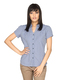

{'items': ["Light Blue Women's Cardigan", 'Beige High-Waisted Trousers', 'Brown Leather Ankle Boots'], 'category': 'Shirts', 'gender': 'Women'}


In [27]:
# Select the unique subcategories from the DataFrame
unique_subcategories = styles_df['articleType'].unique()

# Analyze the image and return the results
analysis = analyze_image(encoded_image, unique_subcategories)
image_analysis = json.loads(analysis)

# Display the image and the analysis results
display(Image(filename=reference_image))
print(image_analysis)

In [28]:
# Extract the relevant features from the analysis
item_descs = image_analysis['items']
item_category = image_analysis['category']
item_gender = image_analysis['gender']


# Filter data such that we only look through the items of the same gender (or unisex) and different category
filtered_items = styles_df.loc[styles_df['gender'].isin([item_gender, 'Unisex'])]
filtered_items = filtered_items[filtered_items['articleType'] != item_category]
print(str(len(filtered_items)) + " Remaining Items")

# Find the most similar items based on the input item descriptions
matching_items = find_matching_items_with_rag(filtered_items, item_descs)

# Display the matching items (this will display 2 items for each description in the image analysis)
html = ""
paths = []
for i, item in enumerate(matching_items):
    item_id = item['id']

    # Path to the image file
    image_path = f'data/sample_clothes/sample_images/{item_id}.jpg'
    paths.append(image_path)
    html += f'<img src="{image_path}" style="display:inline;margin:1px"/>'

# Print the matching item description as a reminder of what we are looking for
print(item_descs)
# Display the image
display(HTML(html))

377 Remaining Items
["Light Blue Women's Cardigan", 'Beige High-Waisted Trousers', 'Brown Leather Ankle Boots']
